# Roman Urdu Sentiment Analysis (Multiclass Classification)

In [887]:
#Import modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import random

from keras import models
from keras import layers
from keras import regularizers

from keras.layers import Embedding, Flatten, Dense
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
import keras
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

## Section 1. Data Prep

In [825]:
os.chdir('D:\MSc2\Deep Learning Keras\Task5')
data = pd.read_csv('Data.csv',header = 0)

In [826]:
#data.head() #(Text, Sentiment)
#data.shape #(20228, 2)
data.describe() #need to normalize

,Text,Sentiment
count,20227,20228
unique,19663,3
top,Good,Neutral
freq,23,8929


In [827]:
data

,Text,Sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive
...,...,...
20223,Hamari jese awam teli laga k mazay leti,Negative
20224,Kaash hum b parhay likhay hotayKabhi likhtay g...,Negative
20225,Bahi sayasat kufrrr ha saaaf bttttt ha qanon s...,Negative
20226,aanti toh gussa e kr gai hain,Negative


In [828]:
#Randomly shuffle the data
data = data.iloc[np.random.permutation(data.shape[0]),].reset_index(drop=True)

In [829]:
data

,Text,Sentiment
0,Phupi ho to billo g ki trah....best acting bil...,Positive
1,Is se phele Snidh games par nazaren hain jis ...,Positive
2,PEMRA Ki Tv Chanals Ko Behuda Ishtiharat Rokne...,Positive
3,oye hoye bt jokes a part is kinza ko drama se ...,Negative
4,Haramiiii Government ..!,Neutral
...,...,...
20223,yar check kr bchy ki acting :),Neutral
20224,iron tou bohata chee hai aur chaltee bhee wais...,Positive
20225,Pero morshad aij ais rat ko apny maredo kah la...,Neutral
20226,Jahangir Badar ne apni siyasat ka aaghaz 60 ki...,Neutral


In [ ]:
#Map the sentiment to numerical values
labels = data.iloc[:,1]
labels[labels == 'Positive'] = 2
labels[labels == 'Neutral'] = 1
labels[labels == 'Negative'] = 0
labels = list(labels) #Labels is a lis

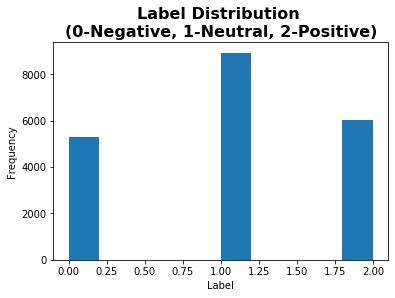

In [869]:
#Balanced Classes
plt.hist(labels)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Distribution \n(0-Negative, 1-Neutral, 2-Positive)',fontweight='bold',fontsize=16)
plt.show()

In [832]:
#Extract the texts
texts = data.iloc[:,0]
texts = list(texts) #Also a list

In [833]:
#Convert every text corpus to string
texts = [str(i) for i in texts]
#set([type(i) for i in texts])

In [834]:
texts[0] #Example

'Phupi ho to billo g ki trah....best acting billo g.....'

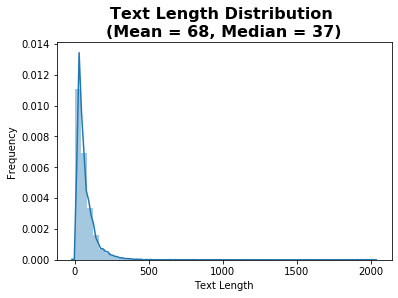

In [870]:
#Check the length of each text
#l = [len(l) for l in texts] #left skewed - median << mean (heavy tails)
sns.distplot(l)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution \n(Mean = 68, Median = 37)',fontweight='bold',fontsize=16)
plt.show()

In [836]:
sum(l)/len(l) #average length = 68

68.25153252916749

In [837]:
q = np.arange(0,100,10) #percentiles of length - median only 37 words long
np.percentile(l, q)

array([  1.,  15.,  23.,  30.,  37.,  47.,  59.,  76., 101., 142.])

In [838]:
#Split into Train vs Test 
q1 = int(data.shape[0]*0.7)
q2 = q1 + int(data.shape[0]*0.2)

labels1 = labels[:q2]
labels2 = labels[q2:]
texts1 = texts[:q2]
texts2 = texts[q2:]

In [839]:
##Tokenize/Vectorize the text 
##Note: Fit the Tokenizer on the training set, but use it on training and test set separately
maxlen = 100  # Cut reviews after xx words
max_words = 10000  # Only consider the top words 

tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(texts1)
sequences1 = tokenizer.texts_to_sequences(texts1) #2D Integer Array of Input - list

In [840]:
#sequences - list of integers (with different lengths)
word_index = tokenizer.word_index #token: dictionary
print('Found %s unique tokens.' % len(word_index))

Found 31284 unique tokens.


In [872]:
#word_index is a dictionary, for example: 'the':1, 'and': 2,etc
#word_index

In [873]:
word_index.keys() #these are the words

dict_keys(['ki', 'ke', 'mein', 'hai', 'ka', 'ko', 'se', 'aur', 'k', 'ne', 'bhi', 'to', 'ho', 'is', 'hain', 'kar', 'ye', 'par', 'tha', 'e', 'allah', 'nahi', 'na', 'aik', 'or', 'in', 'ha', 'wo', 'me', 'hi', 'main', 'he', 'jo', 'b', 'kiya', 'ap', 'hy', 'khan', 'koi', 'pakistan', 'yeh', 'kay', 'the', 'h', 'kia', 'liye', 'kr', 'un', 'sath', 'thi', 'ya', 'aap', 'apni', 'gaya', 'tu', 'tak', 'bad', 'ga', 'ab', 'us', 'kuch', 'apne', 'say', 'jab', 'ni', 'bohat', 'per', 'jis', 'sy', 'bhai', 'sab', 'nai', 'acha', 'nhi', 'o', 'raha', 'kya', 'lekin', 'hum', 'baat', 'ameen', 'd', 'kisi', 'film', 'gai', 'hasil', 'meri', 'a', 'rahe', 'hota', 'p', 'sirf', '2', 'bht', 'iss', 'kaam', 'diya', 'mai', 'phir', 'achi', 'nay', 'dua', 'do', 'pak', '3', 'de', 'kam', 'wali', 'tou', 'hua', 'ma', 'log', 'saal', 'pe', 'tum', 'and', 'karne', 'ali', 'rahi', 'di', 'hay', 'mera', 'dil', 'khud', 'of', 'bat', 'm', 'kaha', 'gaye', 'pr', 'i', 'ker', 'naam', 'woh', 'g', 'hn', 'hue', 'din', 'han', 'inho', '1', 'aunty', 'ny', '

In [841]:
##Apply the Tokenizer on the Test Set
sequences2 = tokenizer.texts_to_sequences(texts2) #2D Integer Array of Input - list

In [842]:
## Padding - make sure each sequence of integers have the same length
data_train = pad_sequences(sequences1, maxlen=maxlen) #padded input with 0's
labels_train = np.asarray(labels1)
labels_train = to_categorical(labels_train)
print('Shape of text tensor:', data_train.shape)
print('Shape of label tensor:', labels_train.shape)

Shape of text tensor: (18204, 100)
Shape of label tensor: (18204, 3)


In [648]:
#indices = np.arange(data_train.shape[0]) #(0,1,...,24999)
#np.random.shuffle(indices) #indices from 0 to 24999 are randomly shuffled
#data_train = data_train[indices] #shuffle the texts
#labels_train = labels_train[indices] #shuffle the labels

In [843]:
#Divide into Training and Dev sets
x_train = data_train [:q1]
y_train = labels_train[:q1]
x_val = data_train [q1:]
y_val = labels_train[q1:]

In [844]:
#For the Test set
x_test = pad_sequences(sequences2, maxlen=maxlen) #Test data is already padded with 0's is applicable
y_test = np.asarray(labels2)
y_test = to_categorical(y_test)

In [845]:
#Check the data
print('Shape of training text tensor:',x_train.shape)
print('Shape of validation text tensor:',x_val.shape)
print('Shape of test text tensor:',x_test.shape)
print('Shape of training label tensor:',y_train.shape)
print('Shape of validation label tensor:',y_val.shape)
print('Shape of test label tensor:',y_test.shape)

Shape of training text tensor: (14159, 100)
Shape of validation text tensor: (4045, 100)
Shape of test text tensor: (2024, 100)
Shape of training label tensor: (14159, 3)
Shape of validation label tensor: (4045, 3)
Shape of test label tensor: (2024, 3)


In [684]:
#Check the distribution of labels
#plt.hist(y_train)

In [685]:
#plt.hist(y_val)

In [686]:
#plt.hist(y_test)

## Section 2. Baseline Models 

### Random Guess 

In [689]:
y_test_copy = copy.copy(y_test)
np.random.shuffle(y_test_copy)

l = []
for i in range(0,y_test.shape[0]): 
    l.append(np.array_equal(y_test[i],y_test_copy[i]))

sum(l)/len(l)
#a random guess tends to get an accuracy of 36%

0.3606719367588933

### Gradient Boosting

In [878]:
Y_train = np.asarray(data.iloc[:,1][:q1]).astype('int32')
Y_val = np.asarray(data.iloc[:,1][q1:q2]).astype('int32')
Y_test = np.asarray(data.iloc[:,1][q2:]).astype('int32')
X = data_train
Y = np.asarray(data.iloc[:,1][:q2]).astype('int32')

In [795]:
#Tune the learning rate
learning_rates = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
for lr in learning_rates:
    model_tree = ensemble.GradientBoostingClassifier(n_estimators=50, learning_rate = lr, random_state = 0)
    model_tree.fit(x_train, Y_train)
    print("Learning rate: ", lr)
    print("Accuracy score (training): {0:.3f}".format(model_tree.score(x_train, Y_train))) #mean accuracy
    print("Accuracy score (validation): {0:.3f}".format(model_tree.score(x_val, Y_val)))
    print()

Learning rate:  0.01
Accuracy score (training): 0.457
Accuracy score (validation): 0.436

Learning rate:  0.05
Accuracy score (training): 0.502
Accuracy score (validation): 0.470

Learning rate:  0.1
Accuracy score (training): 0.524
Accuracy score (validation): 0.468

Learning rate:  0.25
Accuracy score (training): 0.567
Accuracy score (validation): 0.480

Learning rate:  0.5
Accuracy score (training): 0.608
Accuracy score (validation): 0.486

Learning rate:  0.75
Accuracy score (training): 0.635
Accuracy score (validation): 0.483

Learning rate:  1
Accuracy score (training): 0.647
Accuracy score (validation): 0.488



In [ ]:
#Note that there is a tradeoff b/t learning rate and # of estimators

In [799]:
model_tree = ensemble.GradientBoostingClassifier(n_estimators=1000, learning_rate = 0.5)
model_tree.fit(X,Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [800]:
print("Accuracy score (training): {0:.3f}".format(model_tree.score(x_test, Y_test))) #Accuracy of 54%

Accuracy score (training): 0.540


In [801]:
y_hat = model_tree.predict(x_test)
y = np.asarray(data.iloc[:,1][q2:]).astype('int32')
#sum(y == y_hat)/len(y)

In [802]:
#Error Analysis
confusion_matrix(y, y_hat)

array([[178, 220, 108],
       [143, 624, 148],
       [107, 205, 291]], dtype=int64)

### Multinomial Logistic Regression

In [882]:
MLR = LogisticRegression(C=1, solver='lbfgs', multi_class='multinomial')
MLR.fit(X,Y)

y_pred = MLR.predict(x_test)

C:\Users\ERIC\Anaconda3\envs\tensorflow_cpu\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [884]:
print("The accuracy of the multinomial logistic regression classifier is: ", sum(y_pred == y)/len(y)) 
##Accuracy of 44%

The accuracy of the multinomial logistic regression classifier is:  0.4407114624505929


### SVM

In [888]:
#First construct a SVM classifier using the RBF kernel
from sklearn.svm import SVC
SVM = SVC(C=1,kernel='rbf',gamma='auto')
#SVM.fit(train_x,train_y)

In [889]:
OVA = OneVsRestClassifier(SVM) #One vs All
OVA.fit(X,Y)
y_pred = OVA.predict(x_test)

In [890]:
print("The accuracy of the One-vs-All SVM is: ", sum(y_pred == y)/len(y))
##Accuracy of 44%

The accuracy of the One-vs-All SVM is:  0.43774703557312256


In [891]:
OVO = OneVsOneClassifier(SVM) #One vs One
OVO.fit(X,Y)
y_pred = OVO.predict(x_test)

In [892]:
print("The accuracy of the One-vs-One SVM is: ", sum(y_pred == y)/len(y))
##Accuracy of 44%

The accuracy of the One-vs-One SVM is:  0.4367588932806324


# Section 3.  Densely Connected Networks

In [ ]:
#1)Architecture of the model - Small Single Layer
embedding_dim = 100 #dimension of the dense vector
model0 = models.Sequential()
model0.add(Embedding(max_words, embedding_dim, input_length=maxlen)) #(10000, 100, 100)
model0.add(Flatten())
model0.add(layers.Dense(32, activation='relu')) 
model0.add(layers.Dense(3, activation='softmax')) 

model0.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history0 = model0.fit(x_train, y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(x_val, y_val))

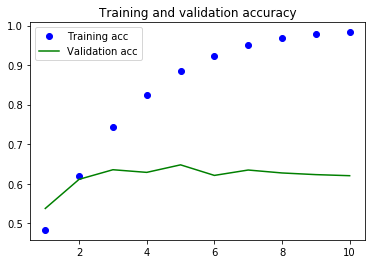

In [695]:
#Accuracy plot - Overfitting quickly after few epochs
acc = history0.history['acc']
val_acc = history0.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
#1)Architecture of the model - Small Single Layer with Regularizations
model0 = models.Sequential()
model0.add(Embedding(max_words, embedding_dim, input_length=maxlen)) #(10000, 100, 100)
model0.add(Flatten())
model0.add(layers.Dense(32, activation='relu')) 
model0.add(layers.Dropout(0.8))
model0.add(layers.Dense(3, activation='softmax')) 

model0.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history0 = model0.fit(x_train, y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val))

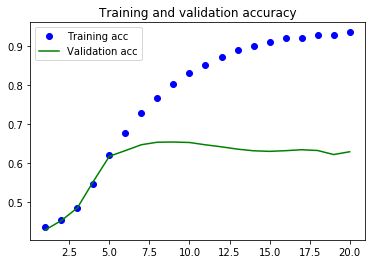

In [737]:
#Accuracy plot - Less overfitting 
acc = history0.history['acc']
val_acc = history0.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [740]:
#Refit the model on whole training set
model0.fit(data_train, labels_train,epochs=10,batch_size=256, verbose = 0)

In [ ]:
#Evaluate the model
model0.evaluate(x_test, y_test) #[2.210492704225623, 0.6086956521739131] - Accuracy of 61%

In [ ]:
##Error Analysis

([array([1226.,  155.,   88.,   44.,   49.,   47.,   46.,   53.,   62.,
          254.]),
  array([817., 111.,  74.,  53.,  45.,  42.,  44.,  49., 130., 659.]),
  array([1214.,  101.,   61.,   48.,   34.,   33.,   48.,   50.,   68.,
          367.])],
 array([5.8019936e-15, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <a list of 3 Lists of Patches objects>)

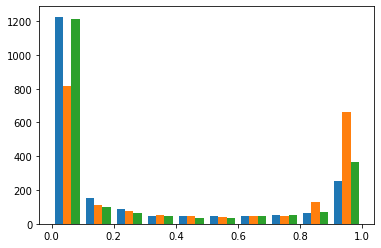

In [720]:
y_pred = model0.predict(x_test) #soft predictions
plt.hist(y_pred)

In [721]:
y_hat = [] #Hard predictions
y = [] 
for i in range(0,y_pred.shape[0]): 
    y_hat.append(np.argmax(y_pred[i]))
    y.append(np.argmax(y_test[i]))

In [722]:
#Error Analysis
confusion_matrix(y, y_hat)

array([[265, 170,  71],
       [138, 613, 164],
       [ 89, 160, 354]], dtype=int64)

# Section 4.  RNN (LSTM)

In [ ]:
#1)Architecture of the model - Small Single LSTM Layer
embedding_dim = 100 #dimension of the dense vector
model1 = models.Sequential()
model1.add(Embedding(max_words, embedding_dim, input_length=maxlen)) #(10000, 100, 100)
model1.add(layers.LSTM(32,
                       dropout=0.4,
                       recurrent_dropout=0.4)) 
model1.add(layers.Dense(3, activation='softmax')) 

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(x_train, y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

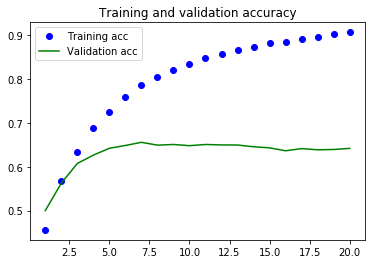

In [812]:
#Accuracy plot - Slightly better performance
##Overfitting quickly after few epochs
##Reaches bottleneck (training accuracy)
acc = history1.history['acc']
val_acc = history1.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
#Refit the model on whole training set
model1.fit(data_train, labels_train,epochs=10,batch_size=256)

In [815]:
#Evaluate the model
model1.evaluate(x_test, y_test) #[1.1958816748833938, 0.633399209486166] - Accuracy of 63%

2024/2024 [==============================] - 1s 597us/step


[1.1958816748833938, 0.633399209486166]

([array([1234.,  157.,   79.,   66.,   48.,   44.,   36.,   40.,   60.,
          260.]),
  array([706., 133.,  82.,  62.,  63.,  75.,  91., 107., 233., 472.]),
  array([1142.,  170.,   82.,   58.,   42.,   44.,   36.,   42.,   69.,
          339.])],
 array([2.2660256e-06, 9.9998333e-02, 1.9999440e-01, 2.9999048e-01,
        3.9998654e-01, 4.9998260e-01, 5.9997869e-01, 6.9997472e-01,
        7.9997081e-01, 8.9996684e-01, 9.9996293e-01], dtype=float32),
 <a list of 3 Lists of Patches objects>)

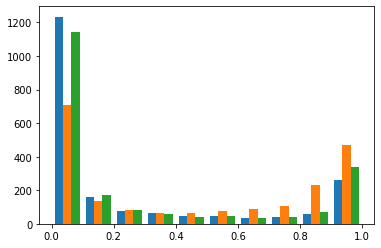

In [816]:
#Error Analysis
y_pred = model1.predict(x_test) #soft predictions
plt.hist(y_pred)

In [817]:
y_hat = [] #Hard predictions
y = [] 
for i in range(0,y_pred.shape[0]): 
    y_hat.append(np.argmax(y_pred[i]))
    y.append(np.argmax(y_test[i]))
    
confusion_matrix(y, y_hat)

array([[276, 170,  60],
       [126, 655, 134],
       [ 63, 189, 351]], dtype=int64)

In [ ]:
#1)Architecture of the model - Bigger Single Layer LSTM 
embedding_dim = 100 #dimension of the dense vector
model1 = models.Sequential()
model1.add(Embedding(max_words, embedding_dim, input_length=maxlen)) #(10000, 100, 100)
#model1.add(layers.LSTM(64,
#                       dropout=0.4,
#                       recurrent_dropout=0.4,
#                       return_sequences=True)) 
model1.add(layers.LSTM(64,
                       dropout=0.2,
                       recurrent_dropout=0.2)) 
model1.add(layers.Dense(3, activation='softmax')) 

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(x_train, y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

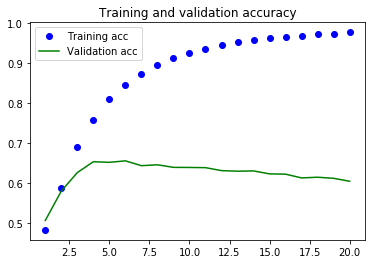

In [851]:
#Accuracy plot - Slightly better performance
##Overfitting quickly after few epochs
##Reaches bottleneck (training accuracy)
acc = history1.history['acc']
val_acc = history1.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
#1)Architecture of the model - Stack two LSTM layers
embedding_dim = 100 #dimension of the dense vector
model1 = models.Sequential()
model1.add(Embedding(max_words, embedding_dim, input_length=maxlen)) #(10000, 100, 100)
model1.add(layers.LSTM(32,
                       dropout=0.4,
                       recurrent_dropout=0.4,
                       return_sequences=True)) 
model1.add(layers.LSTM(32,
                       dropout=0.2,
                       recurrent_dropout=0.2)) 
model1.add(layers.Dense(3, activation='softmax')) 

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(x_train, y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

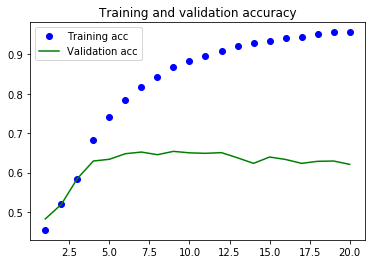

In [867]:
#Accuracy plot - Slightly better performance
##Overfitting quickly after few epochs
##Reaches bottleneck (training accuracy)
acc = history1.history['acc']
val_acc = history1.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Section 5.  Bidirectional RNN (LSTM)

In [ ]:
#1)Architecture of the model - Small Single LSTM Layer
embedding_dim = 100 #dimension of the dense vector
model2 = models.Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=maxlen)) #(10000, 100, 100)
model2.add(layers.Bidirectional(layers.LSTM(32,
                                            dropout=0.2,
                                            recurrent_dropout=0.2))) 
model2.add(layers.Dense(3, activation='softmax')) 
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(x_train, y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(x_val, y_val))

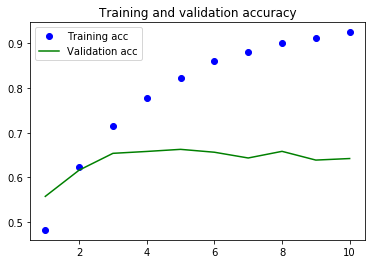

In [855]:
#Accuracy plot
acc = history2.history['acc']
val_acc = history2.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [856]:
#Refit the model on whole training set
model2.fit(data_train, labels_train,epochs=5,batch_size=256)

Epoch 1/5
18204/18204 [==============================] - 243s 13ms/step - loss: 0.3968 - acc: 0.8654
Epoch 2/5
18204/18204 [==============================] - 204s 11ms/step - loss: 0.3465 - acc: 0.8801
Epoch 3/5
18204/18204 [==============================] - 222s 12ms/step - loss: 0.3135 - acc: 0.8912
Epoch 4/5
18204/18204 [==============================] - 228s 13ms/step - loss: 0.2869 - acc: 0.9006
Epoch 5/5
18204/18204 [==============================] - 229s 13ms/step - loss: 0.2602 - acc: 0.9085


In [857]:
#Evaluate the model
model2.evaluate(x_test, y_test) #[1.1962735780142983, 0.6319169960474308] - Accuracy of 63%

2024/2024 [==============================] - 2s 1ms/step


[1.1962735780142983, 0.6319169960474308]

([array([1176.,  139.,   68.,   60.,   46.,   52.,   42.,   50.,   80.,
          311.]),
  array([671., 150., 102.,  88.,  74.,  58.,  67.,  95., 123., 596.]),
  array([1263.,  130.,   65.,   48.,   45.,   44.,   44.,   60.,   71.,
          254.])],
 array([9.43518899e-06, 1.00004785e-01, 2.00000137e-01, 2.99995482e-01,
        3.99990827e-01, 4.99986172e-01, 5.99981546e-01, 6.99976861e-01,
        7.99972236e-01, 8.99967551e-01, 9.99962926e-01], dtype=float32),
 <a list of 3 Lists of Patches objects>)

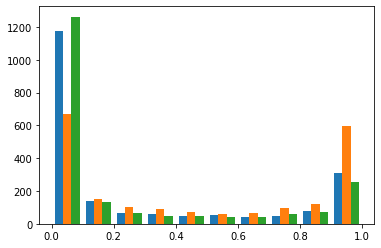

In [858]:
#Error Analysis
y_pred = model2.predict(x_test) #soft predictions
plt.hist(y_pred)

In [859]:
y_hat = [] #Hard predictions
y = [] 
for i in range(0,y_pred.shape[0]): 
    y_hat.append(np.argmax(y_pred[i]))
    y.append(np.argmax(y_test[i]))
    
confusion_matrix(y, y_hat)

array([[319, 156,  73],
       [144, 631,  94],
       [ 99, 179, 329]], dtype=int64)